In [263]:
%%capture

!pip3 install fairseq
!pip3 install sacremoses subword_nmt

In [264]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fairseq.models.transformer import TransformerModel
from copy import deepcopy

In [265]:
os.environ['CUDA_VISIBLE_DEVICES']='3'

In [266]:
dataset = 'wmt14_enfr-fren_two_tokens'

In [267]:
model = TransformerModel.from_pretrained(
  '..',
  checkpoint_file='checkpoints/' + dataset + '/checkpoint_last.pt',
  data_name_or_path='./data/' + dataset
)


loading archive file ..
| [enfr] dictionary: 7096 types
| [fren_two_tokens] dictionary: 7096 types
Namespace(activation_dropout=0.0, activation_fn='relu', adam_betas='(0.9, 0.998)', adam_eps=1e-09, adaptive_input=False, adaptive_softmax_cutoff=None, adaptive_softmax_dropout=0, all_gather_list_size=16384, arch='transformer', attention_dropout=0.1, best_checkpoint_metric='bleu', bpe=None, broadcast_buffers=False, bucket_cap_mb=25, clip_norm=0.0, cpu=False, criterion='label_smoothed_cross_entropy', cross_self_attention=False, curriculum=0, data='/data/anjukirkov/courses/bt/data/wmt14_enfr-fren_two_tokens', dataset_impl=None, ddp_backend='c10d', decoder_attention_heads=8, decoder_embed_dim=512, decoder_embed_path=None, decoder_ffn_embed_dim=2048, decoder_input_dim=512, decoder_layerdrop=0, decoder_layers=6, decoder_layers_to_keep=None, decoder_learned_pos=False, decoder_normalize_before=True, decoder_output_dim=512, device_id=0, disable_validation=False, distributed_backend='nccl', distrib

In [379]:
model.translate('^^^^ I am good')

'@@@@ Je suis bon'

In [269]:
model.modules

<bound method Module.modules of GeneratorHubInterface(
  (models): ModuleList(
    (0): TransformerModel(
      (encoder): TransformerEncoder(
        (embed_tokens): Embedding(7096, 512, padding_idx=1)
        (embed_positions): SinusoidalPositionalEmbedding()
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
            (final_layer_norm): LayerNorm((512,), eps=1e-05, el

In [270]:
def print_layers(title, layers):
    print(title + ': ' + str(len(layers)))
    for layer in layers:
        print(layer)

def get_total_layers(model):
    layers = []
    for layer, _ in model.named_modules():
        layers.append(layer)
    return layers
        
layers = get_total_layers(model)
print_layers('Total layers', layers)

Total layers: 171

models
models.0
models.0.encoder
models.0.encoder.embed_tokens
models.0.encoder.embed_positions
models.0.encoder.layers
models.0.encoder.layers.0
models.0.encoder.layers.0.self_attn
models.0.encoder.layers.0.self_attn.k_proj
models.0.encoder.layers.0.self_attn.v_proj
models.0.encoder.layers.0.self_attn.q_proj
models.0.encoder.layers.0.self_attn.out_proj
models.0.encoder.layers.0.self_attn_layer_norm
models.0.encoder.layers.0.fc1
models.0.encoder.layers.0.fc2
models.0.encoder.layers.0.final_layer_norm
models.0.encoder.layers.1
models.0.encoder.layers.1.self_attn
models.0.encoder.layers.1.self_attn.k_proj
models.0.encoder.layers.1.self_attn.v_proj
models.0.encoder.layers.1.self_attn.q_proj
models.0.encoder.layers.1.self_attn.out_proj
models.0.encoder.layers.1.self_attn_layer_norm
models.0.encoder.layers.1.fc1
models.0.encoder.layers.1.fc2
models.0.encoder.layers.1.final_layer_norm
models.0.encoder.layers.2
models.0.encoder.layers.2.self_attn
models.0.encoder.layers.2.s

In [271]:
def get_head_layers(model, coder, n_head):
    layers = [
        'models.0.{}.layers.{}'.format(coder, n_head),
        'models.0.{}.layers.{}.self_attn'.format(coder, n_head),
        'models.0.{}.layers.{}.self_attn.k_proj'.format(coder, n_head),
        'models.0.{}.layers.{}.self_attn.v_proj'.format(coder, n_head),
        'models.0.{}.layers.{}.self_attn.out_proj'.format(coder, n_head),
        'models.0.{}.layers.{}.self_attn.out_proj'.format(coder, n_head),
        'models.0.{}.layers.{}.fc1'.format(coder, n_head),
        'models.0.{}.layers.{}.fc2'.format(coder, n_head),
        'models.0.{}.layers.{}.final_layer_norm'.format(coder, n_head)
    ]
    
    if coder == 'decoder':
        layers.append('models.0.{}.layers.{}.encoder_attn'.format(coder, n_head))
        layers.append('models.0.{}.layers.{}.encoder_attn.k_proj'.format(coder, n_head))
        layers.append('models.0.{}.layers.{}.encoder_attn.v_proj'.format(coder, n_head))
        layers.append('models.0.{}.layers.{}.encoder_attn.q_proj'.format(coder, n_head))
        layers.append('models.0.{}.layers.{}.encoder_attn.out_proj'.format(coder, n_head))
        layers.append('models.0.{}.layers.{}.encoder_attn_layer_norm'.format(coder, n_head))

    return layers

encoder_head0_layers=get_head_layers(model, 'encoder', n_head=0)
print_layers('Encoder layers for head #0', encoder_head0_layers)

Encoder layers for head #0: 9
models.0.encoder.layers.0
models.0.encoder.layers.0.self_attn
models.0.encoder.layers.0.self_attn.k_proj
models.0.encoder.layers.0.self_attn.v_proj
models.0.encoder.layers.0.self_attn.out_proj
models.0.encoder.layers.0.self_attn.out_proj
models.0.encoder.layers.0.fc1
models.0.encoder.layers.0.fc2
models.0.encoder.layers.0.final_layer_norm


In [272]:
def get_common_layers(model, coder):
    return [
        'models',
        'models.0',
        'models.0.{}'.format(coder),
        'models.0.{}.embed_tokens'.format(coder),
        'models.0.{}.embed_positions'.format(coder),
        'models.0.{}.layers'.format(coder),
        'models.0.{}.layer_norm'.format(coder),
        'models.0.{}.layernorm_embedding'.format(coder),
    ]

common_encoder_layers=get_common_layers(model, 'encoder')
print_layers('Common encoder layers', common_encoder_layers)

Common encoder layers: 8
models
models.0
models.0.encoder
models.0.encoder.embed_tokens
models.0.encoder.embed_positions
models.0.encoder.layers
models.0.encoder.layer_norm
models.0.encoder.layernorm_embedding


In [363]:
def get_layers_output(model, layers, dataset, n_sentenses=2):
    layers_output = dict()
    
    def hook_wr(layer):
        def hook(module, input, output):
            if layers_output[layer] is None:
                layers_output[layer] = []
            if isinstance(output, tuple):
                return
            layers_output[layer].append(output.numpy())
        return hook

    def insert_hooks():
        hooks = []
        for layer, module in model.named_modules():
            if layer in layers:
                hooks.append(module.register_forward_hook(hook_wr(layer)))  
        return hooks
    
    def remove_hooks(hooks):
        for h in hooks:
            h.remove()
        hooks = []
        
    def get_output(token=None):
        layers_output.clear()
        for layer in layers:
            layers_output[layer] = None
            
        for index, sentence in enumerate(open('../data/' + dataset + '/merged/en-fr.enfr')):
            model.translate((token + ' ' if token else '') + sentence)
            if index > n_sentenses:
                break
                
        return deepcopy(layers_output)
    
    hooks = insert_hooks();
    output_no_token = get_output('^^^^')
    output_with_token = get_output('@@@@')
    remove_hooks(hooks)
    
    return output_no_token, output_with_token

    
def get_layers_stats(model, layers, dataset, stat_funcs, n_sentenses=2):
    output_no_token, output_with_token = get_layers_output(model, layers, dataset, n_sentenses)
    data = pd.DataFrame(index=layers, columns=stat_funcs.keys())
    for row, layer in enumerate(layers):
        for column, stat in enumerate(stat_funcs.keys()):
            data.iloc[row, column] = stat_funcs[stat](output_no_token[layer], output_with_token[layer])
            
    return data
            

In [364]:
def num_examples1(out1, out2):
    if out1 is None:
        return None
    
    return len(out1)

def num_examples2(out1, out2):
    if out2 is None:
        return None
    
    return len(out2)

In [365]:
def shape1(out1, out2):
    if out1 is None or len(out1) == 0 or out1[0] is None:
        return None
    
    return np.array(out1[0]).shape

def shape2(out1, out2):
    if out2 is None or len(out2) == 0 or out2[0] is None:
        return None
    
    return np.array(out2[0]).shape

In [366]:
def diff_neurons(out1, out2):
    if out1 is None or out2 is None:
        return None
    if len(out1) == 0 or len(out2) == 0 is None:
        return None
    if out1[0] is None or out2[0] is None:
        return None
    if out1[0].shape != out2[0].shape:
        return None
    
    return np.mean((out1[0] - out2[0]) > 1e-4)
 
def mse(out1, out2):
    if out1 is None or out2 is None:
        return None
    if len(out1) == 0 or len(out2) == 0 is None:
        return None
    if out1[0] is None or out2[0] is None:
        return None
    if out1[0].shape != out2[0].shape:
        return None
    
    return np.mean((out1[0] - out2[0])**2)
        

In [367]:
stat_funcs = dict()
stat_funcs["num_examples1"] = num_examples1
stat_funcs["num_examples2"] = num_examples2
stat_funcs["shape1"] = shape1
stat_funcs["shape2"] = shape2
stat_funcs["diff_neurons"] = diff_neurons
stat_funcs["mse"] = mse

metrics = ['diff_neurons', 'mse']

In [368]:
results = get_layers_stats(model, layers, dataset, stat_funcs)

In [279]:
with pd.option_context("display.max_rows", 1000):
    display(results)

,num_examples1,num_examples2,shape1,shape2,diff_neurons,mse
,None,None,None,None,None,None
models,None,None,None,None,None,None
models.0,None,None,None,None,None,None
models.0.encoder,0,0,None,None,None,None
models.0.encoder.embed_tokens,4,4,"(1, 8, 512)","(1, 8, 512)",0.0632324,0.000952532
models.0.encoder.embed_positions,4,4,"(1, 8, 512)","(1, 8, 512)",0,0
models.0.encoder.layers,None,None,None,None,None,None
models.0.encoder.layers.0,4,4,"(8, 1, 512)","(8, 1, 512)",0.500244,2.70891
models.0.encoder.layers.0.self_attn,0,0,None,None,None,None
models.0.encoder.layers.0.self_attn.k_proj,None,None,None,None,None,None


<Figure size 1152x432 with 0 Axes>

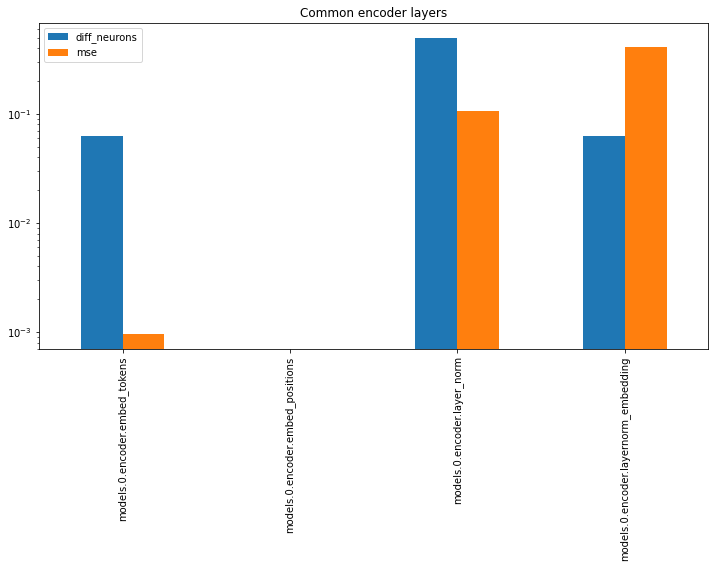

In [353]:
plt.figure(figsize=(16, 6))
results\
    .loc[get_common_layers(model, 'encoder'), metrics]\
    .dropna()\
    .plot.bar(figsize=(12, 6), title='Common encoder layers', log=True)

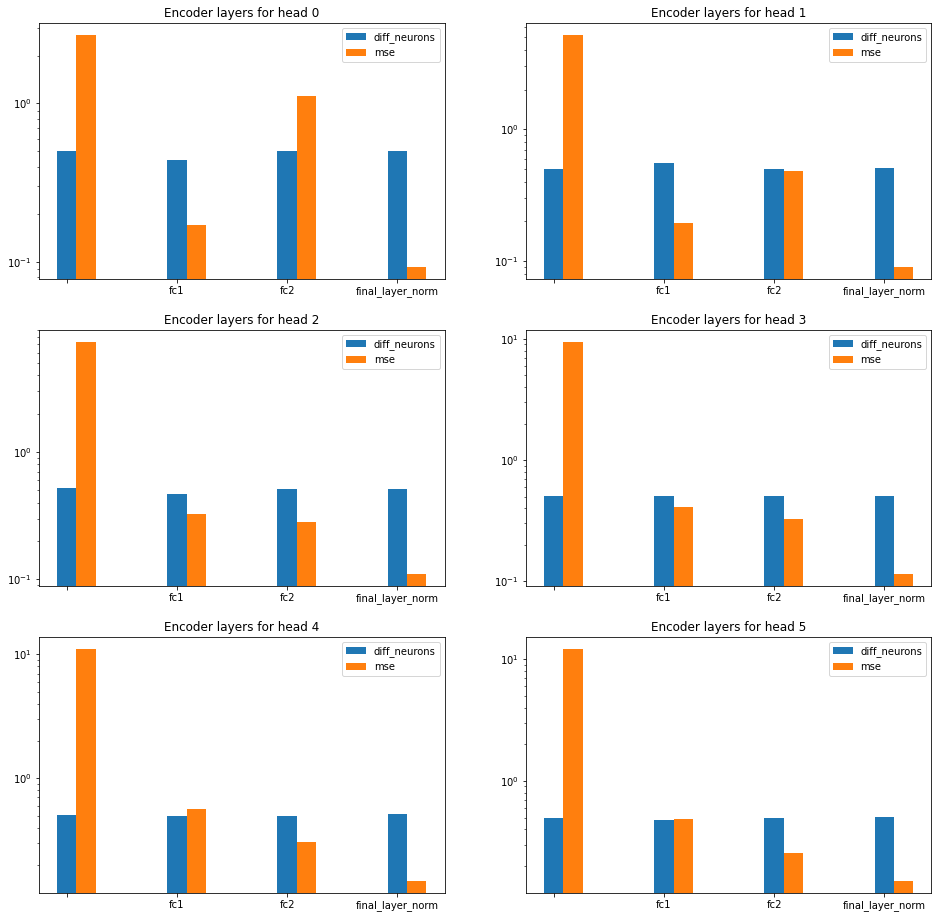

In [352]:
fig, axes = plt.subplots(3, 2, figsize=(16, 16))

for n_head, ax in enumerate(axes.reshape(-1)):
    data = results\
        .loc[get_head_layers(model, 'encoder', n_head), metrics]\
        .dropna()
    
    indices = np.arange(len(data.index))
    width = 0.35
    
    for index, metric in enumerate(metrics):
        ax.bar(indices + index * width / len(metrics), data[metric], width = width / 2, label=metric, log=True)
    ax.set_title('Encoder layers for head {}'.format(n_head))
    ax.set_xticks(indices)
    ax.set_xticklabels([layer[26:] for layer in data.index])
    ax.legend()


<Figure size 1152x432 with 0 Axes>

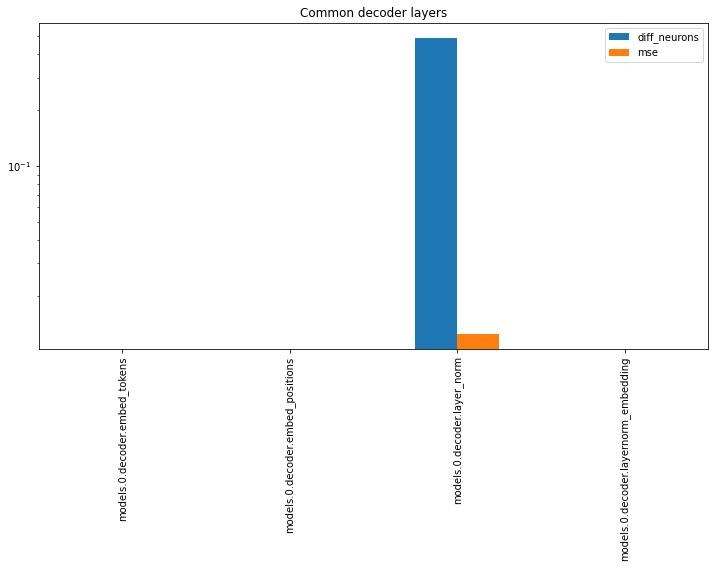

In [354]:
plt.figure(figsize=(16, 6))
results\
    .loc[get_common_layers(model, 'decoder'), metrics]\
    .dropna()\
    .plot.bar(figsize=(12, 6), title='Common decoder layers', log=True)

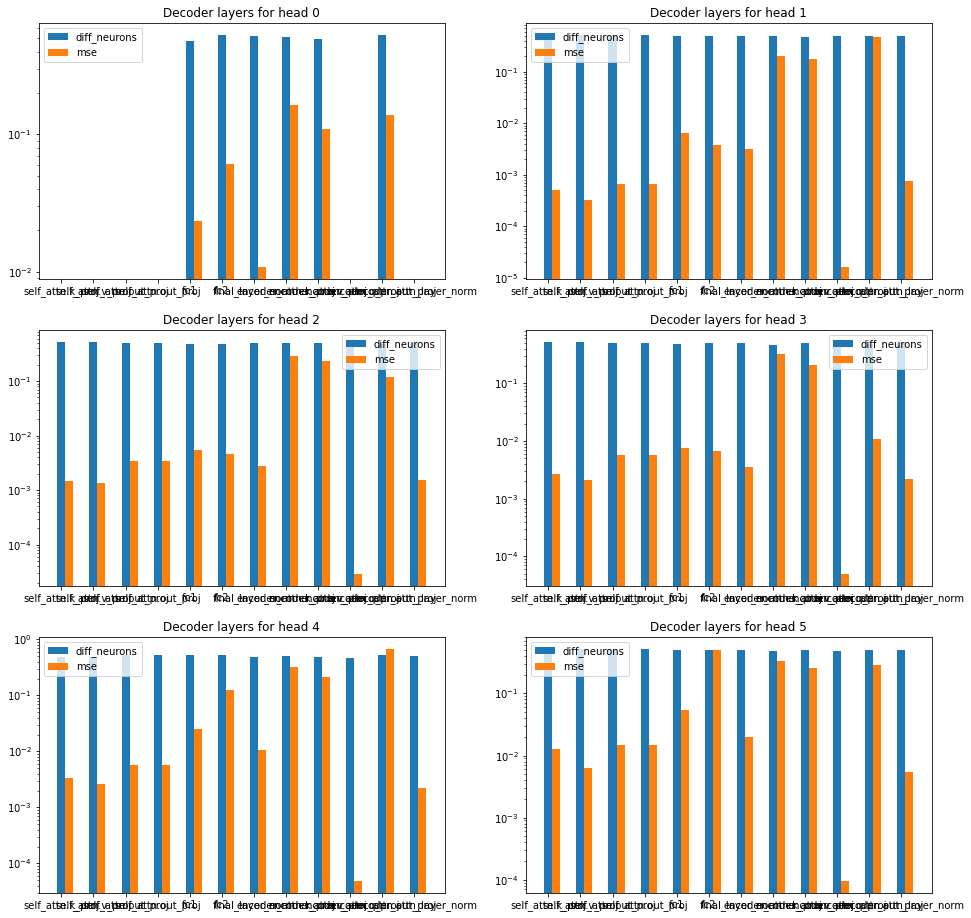

In [356]:
fig, axes = plt.subplots(3, 2, figsize=(16, 16))

for n_head, ax in enumerate(axes.reshape(-1)):
    data = results\
        .loc[get_head_layers(model, 'decoder', n_head), metrics]\
        .dropna()
    
    indices = np.arange(len(data.index))
    width = 0.5
    
    for index, metric in enumerate(metrics):
        ax.bar(indices + index * width / len(metrics), data[metric], width = width / 2, label=metric, log=True)
    ax.set_title('Decoder layers for head {}'.format(n_head))
    ax.set_xticks(indices)
    ax.set_xticklabels([layer[26:] for layer in data.index])
    ax.legend()


In [369]:
a, b = get_layers_output(model, layers, dataset, n_sentenses=2)

In [376]:
a['models.0.encoder.layers.5.final_layer_norm'][1]

array([[[ 0.05260294, -0.07820357,  0.3705516 , ...,  0.1472277 ,
          0.16469549,  0.1166971 ]],

       [[ 0.01581386, -0.11253031,  0.3430897 , ...,  0.13527767,
          0.16060637,  0.11916768]],

       [[-2.1283476 , -1.289657  , -0.18235305, ...,  0.5832274 ,
         -0.08445219,  0.57954097]],

       ...,

       [[-0.38317582,  0.2711759 ,  0.44639942, ...,  0.22091642,
         -1.107004  ,  0.9586973 ]],

       [[ 1.1875547 ,  0.47921228,  0.19896215, ...,  0.26895282,
         -0.5938038 ,  0.7986499 ]],

       [[-0.02904981, -0.090726  ,  0.21657562, ...,  0.255205  ,
          0.05628082,  0.08572621]]], dtype=float32)

In [377]:
b['models.0.encoder.layers.5.final_layer_norm'][1]

array([[[ 0.16757745,  0.36442867,  0.8324098 , ...,  0.22520684,
          0.0835394 , -0.32407844]],

       [[ 0.04042504, -0.1518126 ,  0.37752265, ...,  0.12313893,
          0.17173213,  0.11227139]],

       [[-0.942939  , -1.6569357 , -0.28473526, ...,  0.87485313,
         -0.15149362,  0.47320315]],

       ...,

       [[ 0.12791908,  0.20303579, -0.75985724, ...,  0.38166842,
         -1.2947571 ,  1.5298667 ]],

       [[ 1.1152456 ,  0.21872202,  0.11669205, ...,  0.24250008,
         -0.60983026,  0.7565616 ]],

       [[-0.02040561, -0.12382916,  0.20703079, ...,  0.2317721 ,
          0.04671302,  0.09581502]]], dtype=float32)